In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss, auc, roc_auc_score, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import ast

df = pd.read_csv('/content/drive/MyDrive/FYP/point.csv')

# Filter dataframe to include necessary columns
df_filtered = df[['type', 'group', 'duration', 'step_count', 'stride_length', 'step_length', 'Lknee_angle', 'Rknee_angle',
                  'Lhip_angle', 'Rhip_angle', 'trunk_angle_ver', 'trunk_angle_hor', 'shank_angle',
                  'symmetric_leg', 'symmetric_arm']]

X = df_filtered.drop(columns=['group', 'type'])
y = df_filtered[['group', 'type']]


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=32)

In [14]:
y_test

,group,type
24,NP,0
0,PD,1
16,NP,0
20,NP,0
13,NP,0
6,PD,1
27,NP,0
18,NP,0
17,NP,0


In [15]:
print(X_train.shape, X.shape)
print(y_train.shape, y.shape)

(19, 13) (28, 13)
(19, 2) (28, 2)


In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
# Define parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}

# Create and fit GridSearchCV
grid_search = GridSearchCV(SVC(probability=True), param_grid, refit=True, verbose=3, cv=5)
grid_search.fit(X_train_scaled, y_train['type'])

# Output best parameters and CV score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score: {:.4f}".format(grid_search.best_score_))

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.750 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.750 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.750 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.500 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.667 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=1.000 total time=   0.0s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=1.000 total time=   0.0s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.750 total time=   0.0s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=1.000 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.750 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf

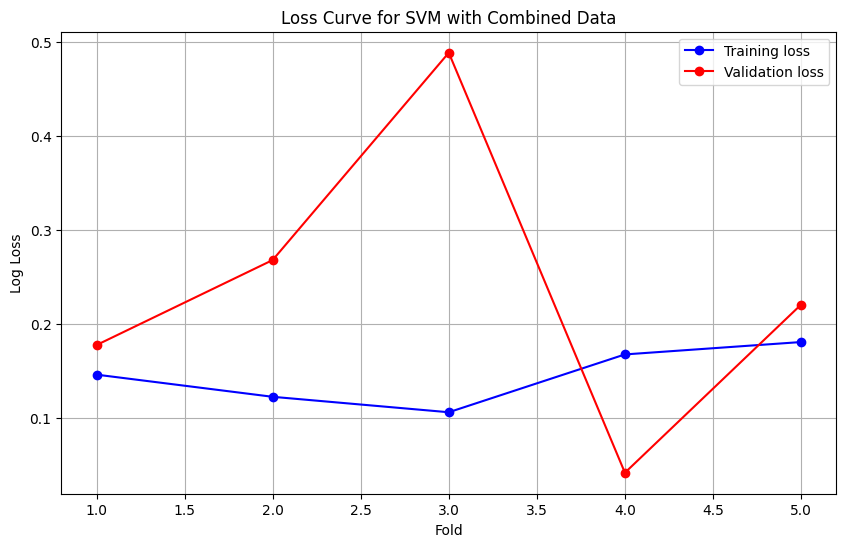

In [18]:
# Use the best estimator found by GridSearchCV
best_svm_model = grid_search.best_estimator_

# Define a custom training loop to track loss, AUC, and ROC using StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=32)
train_losses, val_losses = [], []

for train_index, val_index in skf.split(X_train_scaled, y_train['type']):
    X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_fold, y_val_fold = y_train['type'].iloc[train_index], y_train['type'].iloc[val_index]

    # Check if both classes are present in the fold
    if len(np.unique(y_train_fold)) < 2 or len(np.unique(y_val_fold)) < 2:
        print("Skipping a fold due to only one class present in the fold.")
        continue

    best_svm_model.fit(X_train_fold, y_train_fold)

    y_train_prob = best_svm_model.predict_proba(X_train_fold)
    y_val_prob = best_svm_model.predict_proba(X_val_fold)

    train_loss = log_loss(y_train_fold, y_train_prob)
    val_loss = log_loss(y_val_fold, y_val_prob)

    train_losses.append(train_loss)
    val_losses.append(val_loss)


# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, 'o-', color='blue', label='Training loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, 'o-', color='red', label='Validation loss')

# Plot settings
plt.title('Loss Curve for SVM with Combined Data')
plt.xlabel('Fold')
plt.ylabel('Log Loss')
plt.legend(loc='best')
plt.grid()
plt.show()

In [20]:
# Model Evaluation
y_test_pred = best_svm_model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test['type'], y_test_pred)

y_train_pred = best_svm_model.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train['type'], y_train_pred)

print(f'Test Accuracy: {test_accuracy:.2f}')
print(f'Train Accuracy: {train_accuracy:.2f}')

print("Classification Report (Test Set):")
print(classification_report(y_test['type'], y_test_pred))

# Calculate AUC and plot ROC curve for test set
y_prob_test = grid_search.best_estimator_.decision_function(X_test_scaled)
fpr, tpr, thresholds = roc_curve(y_test['type'], y_prob_test)
roc_auc = auc(fpr, tpr)
print(f'AUC: {roc_auc:.4f}')

Test Accuracy: 0.89
Train Accuracy: 0.95
Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      0.50      0.67         2

    accuracy                           0.89         9
   macro avg       0.94      0.75      0.80         9
weighted avg       0.90      0.89      0.87         9

AUC: 0.6429


In [21]:
# Confusion matrix for training set
train_conf_matrix = confusion_matrix(y_train['type'], y_train_pred)

# Confusion matrix for testing set
test_conf_matrix = confusion_matrix(y_test['type'], y_test_pred)

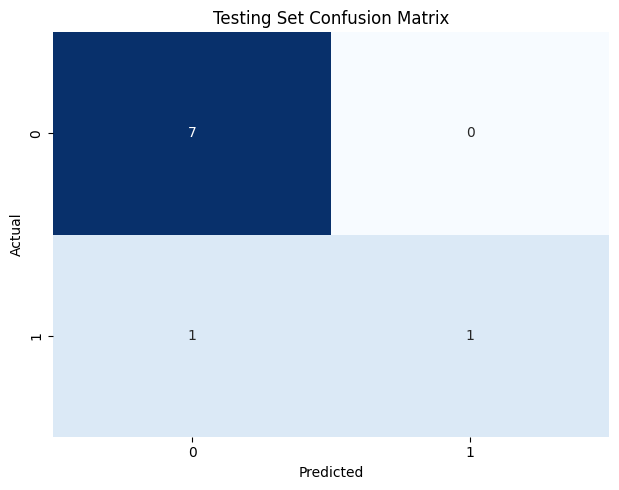

In [27]:
plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
# plt.title('Training Set Confusion Matrix')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')

plt.subplot(1, 2, 2)
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Testing Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

In [23]:
# Calculate AUC and plot ROC curve for test set
y_prob_test = best_svm_model.decision_function(X_test_scaled)
fpr, tpr, thresholds = roc_curve(y_test['type'], y_prob_test)
roc_auc = auc(fpr, tpr)
print(f'AUC: {roc_auc:.4f}')

AUC: 0.6429


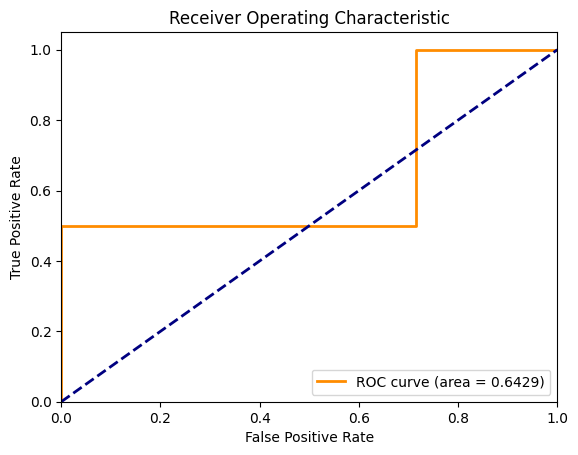

In [24]:
# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [26]:
from sklearn.model_selection import cross_val_score

# Cross-validation score
cv_scores = cross_val_score(best_svm_model, X_train_scaled, y_train['type'], cv=5)
print(f'Cross-validation scores: {cv_scores}')
print(f'Mean cross-validation score: {cv_scores.mean():.4f}')

Cross-validation scores: [0.75 1.   1.   0.75 1.  ]
Mean cross-validation score: 0.9000
